In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/capstone_project_data" "/content/capstone_project_data"


Mounted at /gdrive


In [2]:
# Install required libraries
!pip install matplotlib seaborn scikit-learn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
files = {
    "AgeGroup": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-AgeGroup.xlsx",
    "Citz": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-Citz.xlsx",
    "CitzImmCat": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-CitzImmCat.xlsx",
    "CMA": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-CMA.xlsx",
    "ProvImmCat": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-ProvImmCat.xlsx",
}

In [4]:
# Load all datasets
datasets = {name: pd.ExcelFile(path) for name, path in files.items()}

In [5]:
# Extract sheet names for each file
sheet_names = {name: dataset.sheet_names for name, dataset in datasets.items()}

In [6]:
# Load the sheets into DataFrames
dfs = {
    "AgeGroup": datasets["AgeGroup"].parse("PR - Age"),
    "CMA": datasets["CMA"].parse("PR - CMA"),
    "CitzImmCat": datasets["CitzImmCat"].parse("PR - ImmCat"),
    "Citz": datasets["Citz"].parse("PR - CITZ"),
}

In [7]:
# Clean datasets
def clean_dataframe(df):
    df = df.dropna(how='all')  # Drop completely empty rows
    df.columns = df.iloc[1]  # Use second row as header
    df = df[2:].reset_index(drop=True)  # Drop previous header rows
    df = df.dropna(axis=1, how='all')  # Drop empty columns
    return df

In [8]:
# Apply cleaning function
cleaned_dfs = {name: clean_dataframe(df) for name, df in dfs.items()}

In [9]:

# Function to extract relevant data dynamically
def clean_extract(df, header_idx, key_col_name, total_col_name):
    """Extracts and cleans relevant data dynamically."""
    df = df.dropna(how="all").reset_index(drop=True)  # Remove empty rows
    df.columns = df.iloc[header_idx]  # Set correct headers
    df = df[(header_idx + 1):].reset_index(drop=True)  # Remove previous headers

    # Ensure key column and total admissions column exist
    if key_col_name in df.columns and total_col_name in df.columns:
        df = df[[key_col_name, total_col_name]].dropna()
        df.columns = ["Category", "Total Admissions"]

        # Clean numeric values
        #df["Total Admissions"] = df["Total Admissions"].astype(str).str.replace(",", "").replace("--", "0").astype(int)
        df["Total Admissions"] = df["Total Admissions"].fillna("0").astype(str).str.replace(",", "").replace("--", "0").astype(int)
        return df

    return None

In [10]:
# Manually setting correct column names
column_names_manual = {
    "AgeGroup": ("0 to 14 years old", "1,465"),
    "CMA": ("St. John's", "3,985"),
    "CitzImmCat": ("Worker Program", "85"),
    "Citz": ("Afghanistan", "12,280"),
}

header_indices = {
    "AgeGroup": 1,
    "CMA": 1,
    "CitzImmCat": 6,
    "Citz": 1,
}

In [11]:
# Apply extraction method to datasets
age_group_df = clean_extract(cleaned_dfs["AgeGroup"], header_indices["AgeGroup"], *column_names_manual["AgeGroup"])
cma_df = clean_extract(cleaned_dfs["CMA"], header_indices["CMA"], *column_names_manual["CMA"])
imm_cat_df = clean_extract(cleaned_dfs["CitzImmCat"], header_indices["CitzImmCat"], *column_names_manual["CitzImmCat"])
citizenship_df = clean_extract(cleaned_dfs["Citz"], header_indices["Citz"], *column_names_manual["Citz"])


In [12]:
import json

def format_df_for_json(df):
    """Formats a DataFrame for JSON output with indentation."""
    if df is not None:
        return df.to_dict(orient='records')  # Convert to list of dicts
    else:
        return "Extraction Failed"


extracted_results = {
    "Age Group": format_df_for_json(age_group_df.head()),
    "CMA": format_df_for_json(cma_df.head()),
    "Immigration Category": format_df_for_json(imm_cat_df.head()),
    "Citizenship": format_df_for_json(citizenship_df.head()),
}

# Convert to JSON string with indentation
extracted_results_json = json.dumps(extracted_results, indent=4)

# Print the indented JSON
print(extracted_results_json)

{
    "Age Group": [
        {
            "Category": "15 to 29 years old",
            "Total Admissions": 1530
        },
        {
            "Category": "30 to 44 years old",
            "Total Admissions": 2260
        },
        {
            "Category": "45 to 59 years old",
            "Total Admissions": 420
        },
        {
            "Category": "60 to 74 years old",
            "Total Admissions": 70
        },
        {
            "Category": "75 years old or more",
            "Total Admissions": 5
        }
    ],
    "CMA": [
        {
            "Category": "Corner Brook",
            "Total Admissions": 275
        },
        {
            "Category": "Gander",
            "Total Admissions": 230
        },
        {
            "Category": "Grand Falls-Windsor",
            "Total Admissions": 75
        },
        {
            "Category": "Other - Newfoundland and Labrador",
            "Total Admissions": 1190
        },
        {
            "Category": 

In [13]:
file_path = files["ProvImmCat"]
excel_file = pd.ExcelFile(file_path)

In [14]:
# Extract and clean Provincial Immigration Categories
def extract_provincial_immigration(df):
    header_index = 3  # Adjusted based on observation
    df.columns = df.iloc[header_index]
    df = df[(header_index + 1):].reset_index(drop=True)
    df = df.dropna(axis=1, how='all')
    df = df.iloc[:, [3, -1]]  # Selecting Province and Total Admissions
    df.columns = ["Province", "Total Admissions"]
    df["Total Admissions"] = df["Total Admissions"].fillna("0").astype(str).str.replace(",", "").replace("--", "0").astype(int)
    df = df.dropna(subset=["Province"])
    return df

In [15]:
# Load the sheet and apply extraction
df_prov_imm_cat = excel_file.parse("PR - ImmCat")
prov_imm_cat_df = extract_provincial_immigration(df_prov_imm_cat)

In [16]:
# Store the cleaned dataset
cleaned_dfs["ProvImmCat"] = prov_imm_cat_df

In [17]:
# Display the cleaned dataset in Jupyter
from IPython.display import display
display(prov_imm_cat_df)

,Province,Total Admissions
0,Agri-Food Pilot,0
1,Atlantic Immigration Pilot Programs,15
2,Atlantic Immigration Programs,1075
3,Canadian Experience,60
4,Caregiver,10
...,...,...
361,Sponsored Children,5
362,Sponsored Extended Family Member,0
363,Sponsored Parent or Grandparent,10
364,Sponsored Spouse or Partner,35


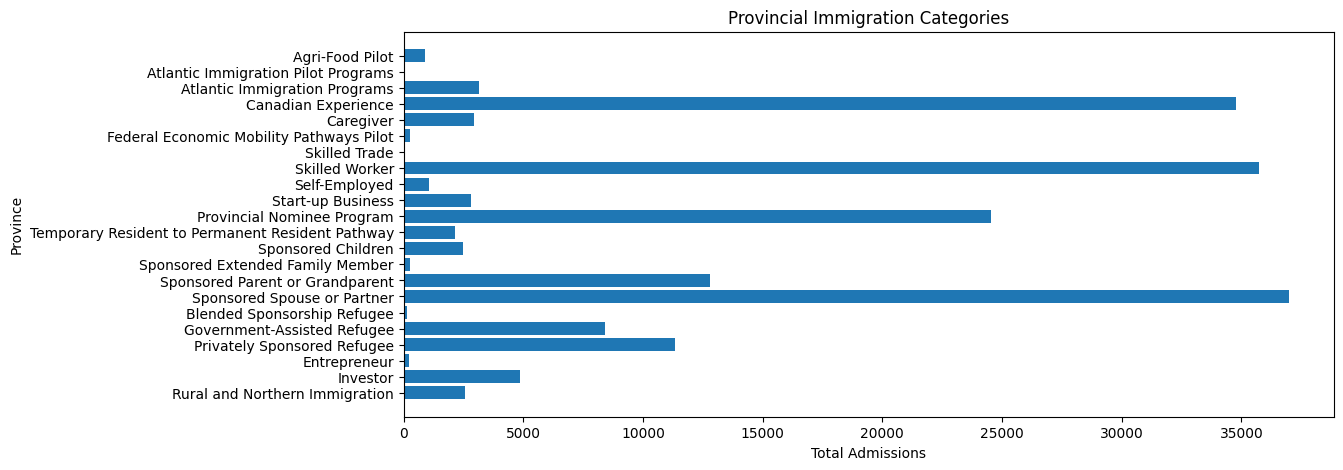

In [18]:
# Visualization: Provincial Immigration Categories
plt.figure(figsize=(12, 5))
plt.barh(prov_imm_cat_df["Province"], prov_imm_cat_df["Total Admissions"])
plt.xlabel("Total Admissions")
plt.ylabel("Province")
plt.title("Provincial Immigration Categories")
plt.gca().invert_yaxis()
plt.show()

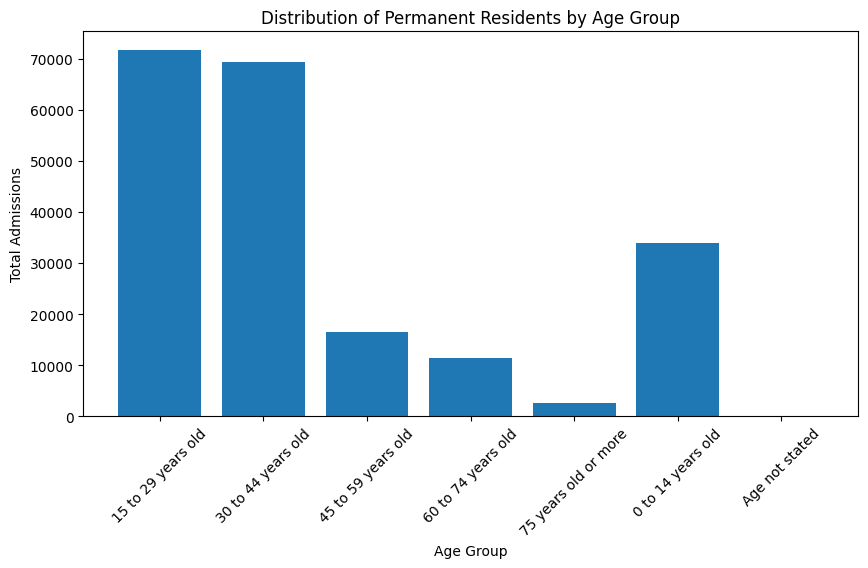

In [19]:
import matplotlib.pyplot as plt

# Age Group Distribution
plt.figure(figsize=(10, 5))
plt.bar(age_group_df["Category"], age_group_df["Total Admissions"])
plt.xlabel("Age Group")
plt.ylabel("Total Admissions")
plt.title("Distribution of Permanent Residents by Age Group")
plt.xticks(rotation=45)
plt.show()


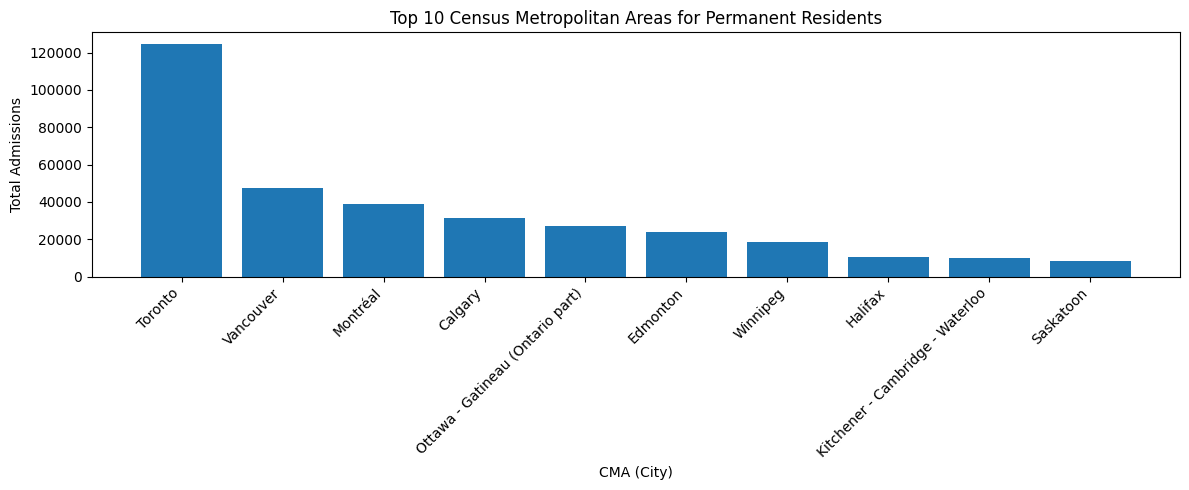

In [20]:

# Preferred CMAs

# Sort by Total Admissions and get top 10
top_10_cma_df = cma_df.sort_values(by="Total Admissions", ascending=False).head(10)

# Now plot using this filtered DataFrame
plt.figure(figsize=(12, 5))  # Adjust figure size for better readability
plt.bar(top_10_cma_df["Category"], top_10_cma_df["Total Admissions"])
plt.xlabel("CMA (City)")
plt.ylabel("Total Admissions")
plt.title("Top 10 Census Metropolitan Areas for Permanent Residents")
plt.xticks(rotation=45, ha='right')  # Rotate and align labels for better visibility
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()

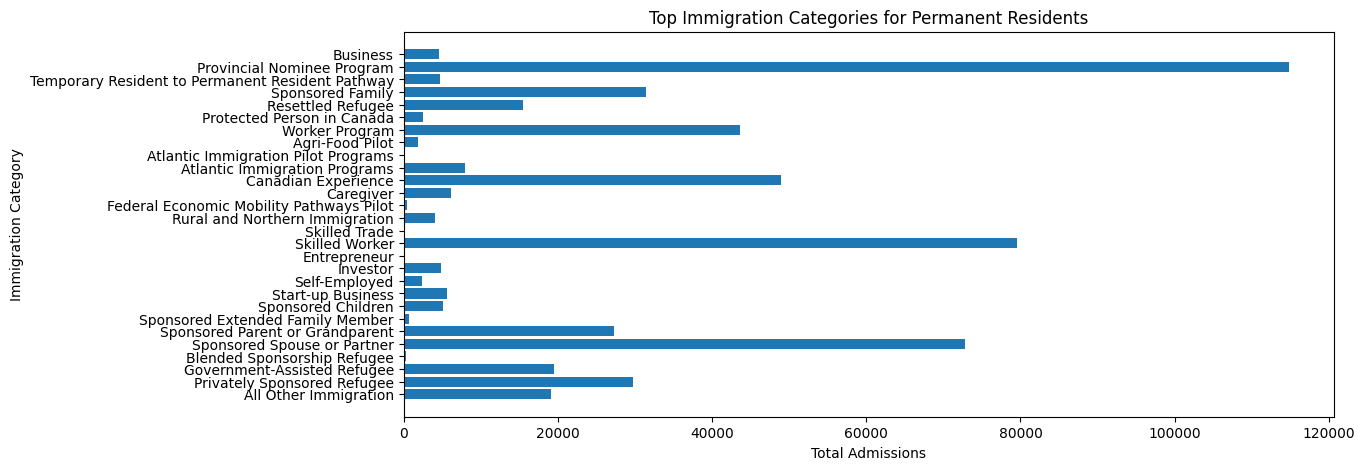

In [21]:
# Immigration Categories
plt.figure(figsize=(12, 5))
plt.barh(imm_cat_df["Category"], imm_cat_df["Total Admissions"])
plt.xlabel("Total Admissions")
plt.ylabel("Immigration Category")
plt.title("Top Immigration Categories for Permanent Residents")
plt.gca().invert_yaxis()
plt.show()

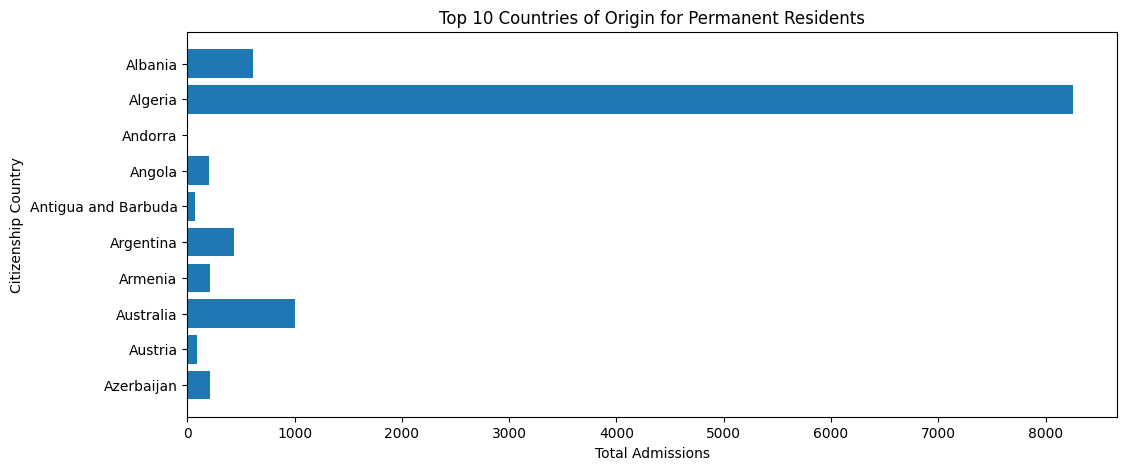

In [22]:
#Citizenship Trends
plt.figure(figsize=(12, 5))
plt.barh(citizenship_df["Category"].head(10), citizenship_df["Total Admissions"].head(10))
plt.xlabel("Total Admissions")
plt.ylabel("Citizenship Country")
plt.title("Top 10 Countries of Origin for Permanent Residents")
plt.gca().invert_yaxis()
plt.show()

In [23]:
# Load the Excel file
file_path = files["CMA"]
xls = pd.ExcelFile(file_path)

In [26]:
# Load the sheet without specifying columns to preserve structure
sheet_name = "PR - CMA"
df_full = pd.read_excel(xls, sheet_name=sheet_name, skiprows=3)

In [ ]:
# Identifying the correct column for province names
province_column = df_full.columns[0]  # First column contains province names

In [27]:
# Identifying the columns that contain yearly total values (last occurrence of each year)
yearly_total_columns = {}
for year in range(2015, 2025):
    matching_cols = [col for col in df_full.columns if str(year) in str(col)]
    if matching_cols:
        yearly_total_columns[year] = matching_cols[-1]  # Last occurrence is likely the total

# Extracting only the relevant columns
df_extracted = df_full[[province_column] + list(yearly_total_columns.values())].copy()

# Renaming columns
df_extracted.rename(columns={province_column: "Province/Territory", **{v: k for k, v in yearly_total_columns.items()}}, inplace=True)

# Cleaning province names
df_extracted["Province/Territory"] = df_extracted["Province/Territory"].astype(str).str.strip()

# Convert numerical columns to proper format by removing commas
for col in range(2015, 2025):
    df_extracted[col] = df_extracted[col].astype(str).str.replace(',', '', regex=True)
    df_extracted[col] = pd.to_numeric(df_extracted[col], errors='coerce')

In [28]:
# Defining the required provinces/territories
required_provinces = [
    "Newfoundland and Labrador Total", "Prince Edward Island Total", "Nova Scotia Total",
    "New Brunswick Total", "Quebec Total", "Ontario Total", "Manitoba Total",
    "Saskatchewan Total", "Alberta Total", "British Columbia Total", "Yukon Total",
    "Northwest Territories Total", "Nunavut Total"
]

# Filtering for the required provinces/territories after cleaning names
df_final_cleaned = df_extracted[df_extracted["Province/Territory"].isin(required_provinces)]

# Save the final extracted data to a CSV file for review
df_final_cleaned.to_csv("final_extracted_yearly_totals.csv", index=False)

# Print first few rows to verify output
print(df_final_cleaned.head())

                 Province/Territory     2015     2016     2017     2018  \
6   Newfoundland and Labrador Total   1120.0   1200.0   1185.0   1525.0   
10       Prince Edward Island Total   1190.0   2315.0   2345.0   2125.0   
17                Nova Scotia Total   3425.0   5510.0   4515.0   5985.0   
26              New Brunswick Total   2580.0   4715.0   3660.0   4610.0   
59                     Quebec Total  49015.0  53235.0  52380.0  51125.0   

       2019     2020     2021     2022     2023     2024  
6    1855.0    900.0   2045.0   3495.0   5485.0   5755.0  
10   2445.0   1290.0   2615.0   2670.0   3620.0   3980.0  
17   7595.0   3520.0   9170.0  12655.0  11805.0  14285.0  
26   6005.0   2890.0   5315.0  10230.0  11460.0  15490.0  
59  40565.0  25240.0  50275.0  68715.0  52810.0  59425.0  


In [29]:
# Load the sheet
sheet_name = "PR - CMA"
df_full = pd.read_excel(xls, sheet_name=sheet_name, skiprows=3)

In [30]:
# Identify province column
province_column = df_full.columns[0]

In [31]:
# Identify yearly total columns
yearly_total_columns = {}
for year in range(2015, 2025):
    matching_cols = [col for col in df_full.columns if str(year) in str(col)]
    if matching_cols:
        yearly_total_columns[year] = matching_cols[-1]

# Extract relevant columns
df_extracted = df_full[[province_column] + list(yearly_total_columns.values())].copy()

# Rename columns
df_extracted.rename(columns={province_column: "Province/Territory", **{v: k for k, v in yearly_total_columns.items()}}, inplace=True)

# Clean province names
df_extracted["Province/Territory"] = df_extracted["Province/Territory"].astype(str).str.strip()

# Convert numerical columns
for col in range(2015, 2025):
    df_extracted[col] = df_extracted[col].astype(str).str.replace(',', '', regex=True)
    df_extracted[col] = pd.to_numeric(df_extracted[col], errors='coerce')


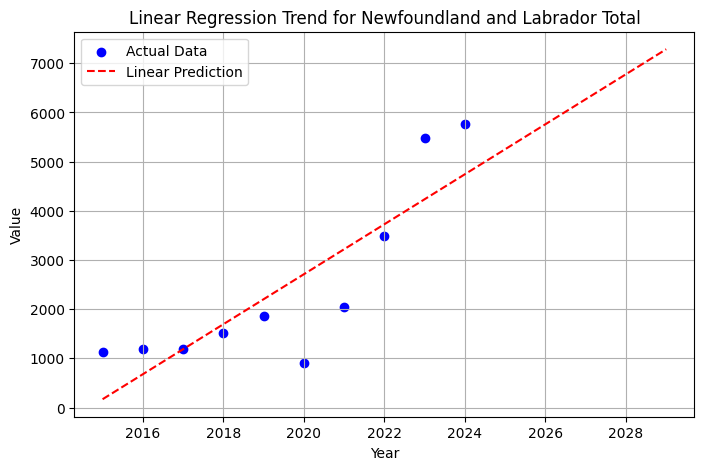

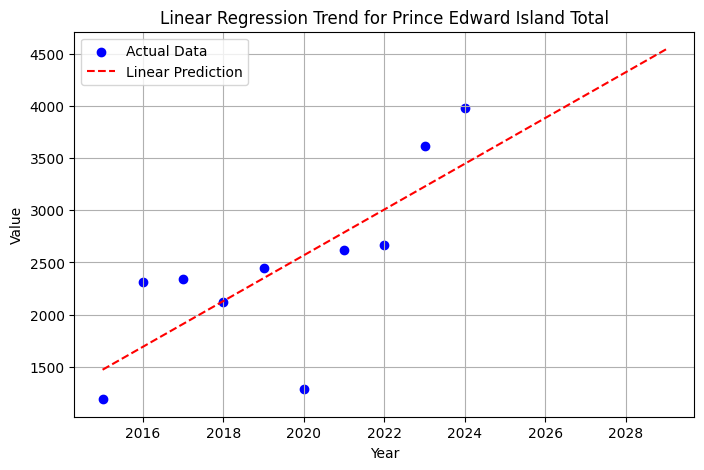

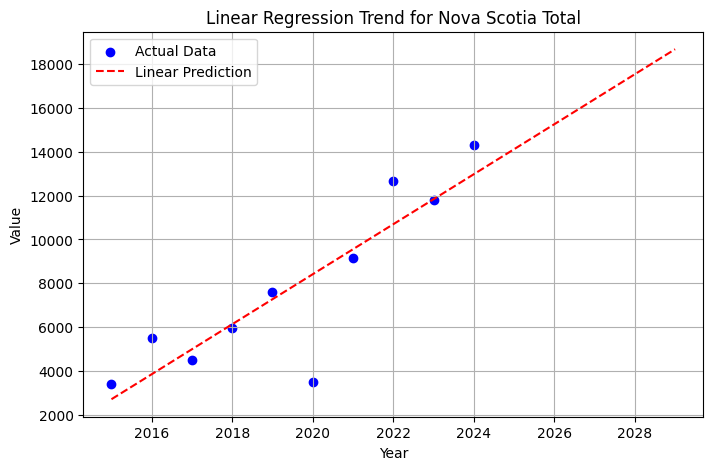

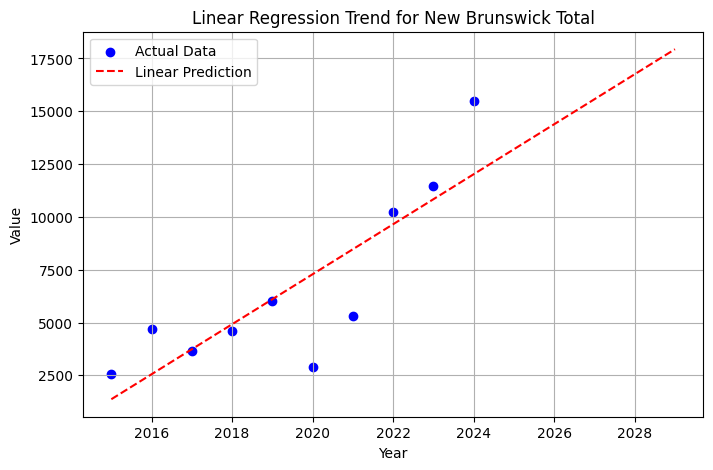

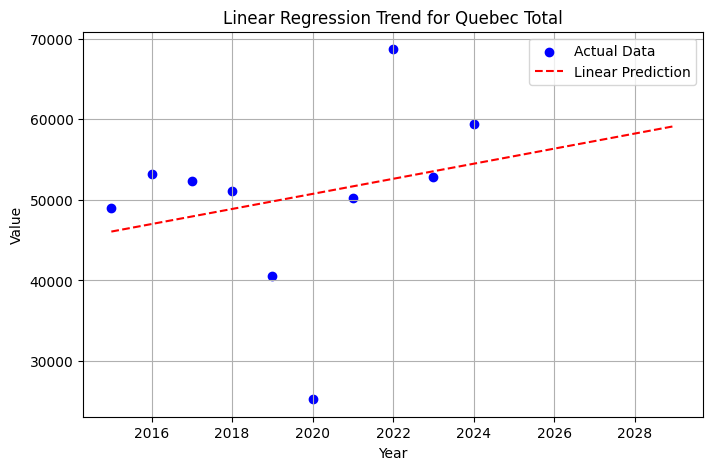

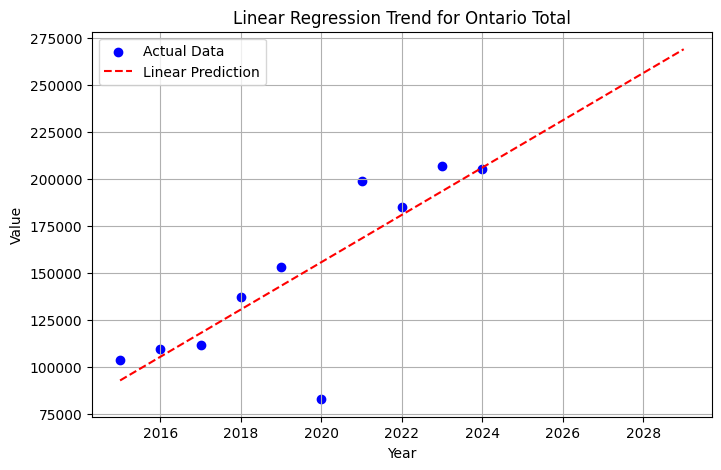

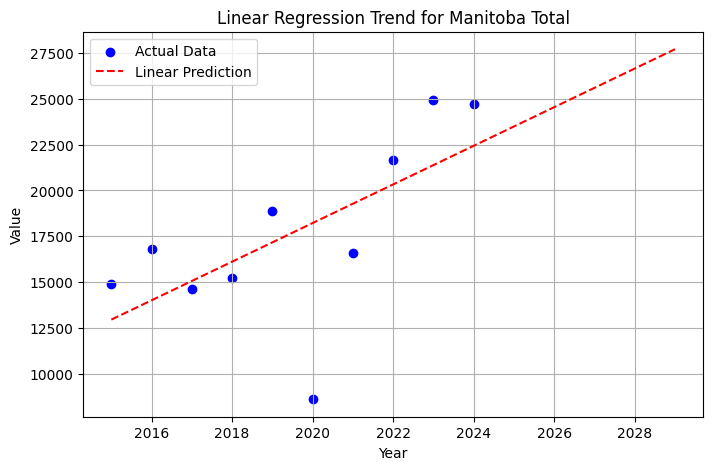

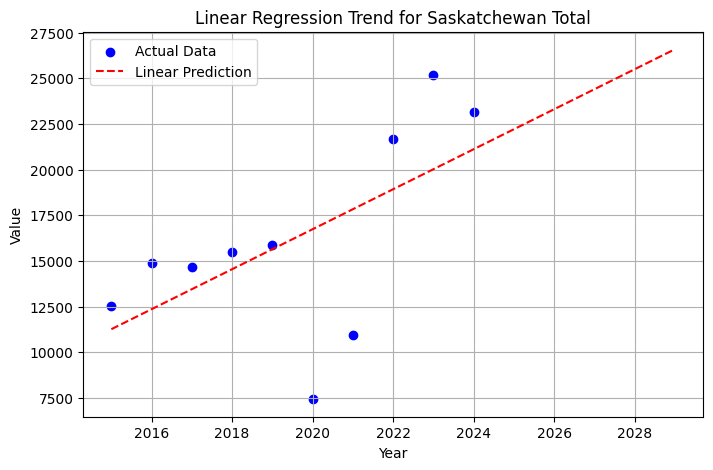

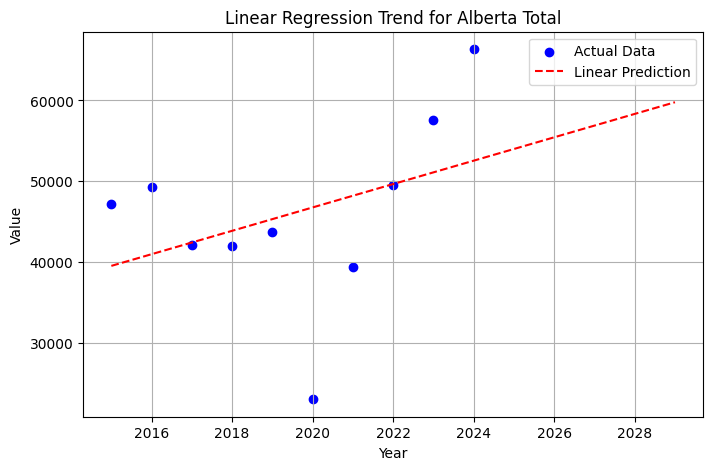

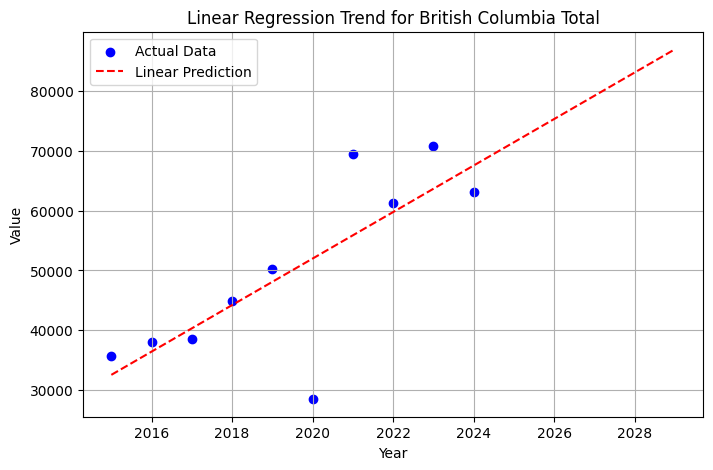

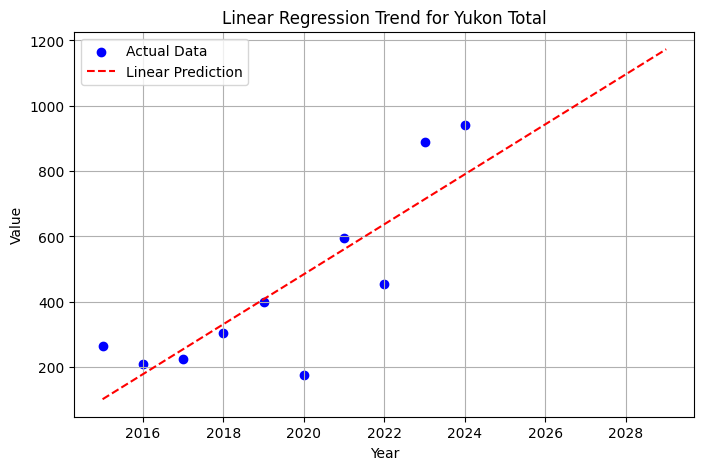

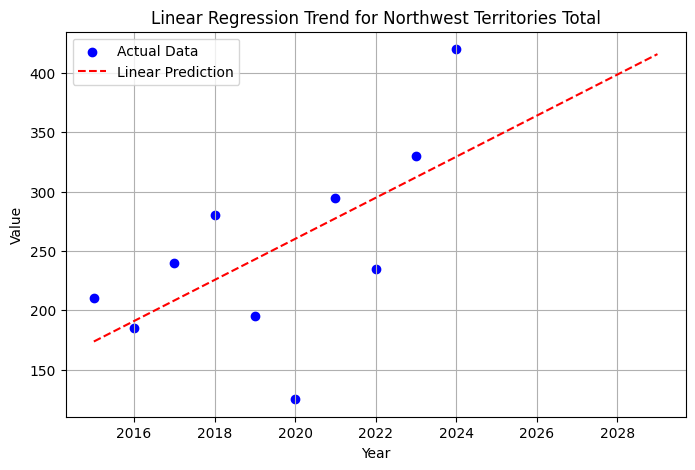

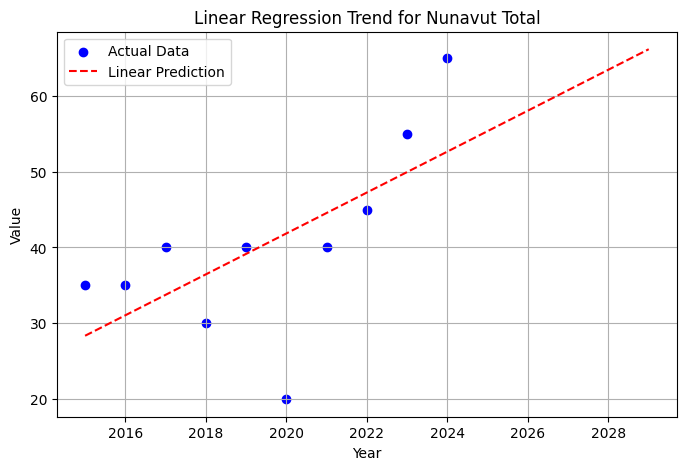

In [32]:
# Required provinces
required_provinces = [
    "Newfoundland and Labrador Total", "Prince Edward Island Total", "Nova Scotia Total",
    "New Brunswick Total", "Quebec Total", "Ontario Total", "Manitoba Total",
    "Saskatchewan Total", "Alberta Total", "British Columbia Total", "Yukon Total",
    "Northwest Territories Total", "Nunavut Total"
]

# Filter for required provinces
df_final_cleaned = df_extracted[df_extracted["Province/Territory"].isin(required_provinces)]

# Prepare data for Linear Regression
years = np.array(list(range(2015, 2025))).reshape(-1, 1)

# Create a plot for each province
for province in df_final_cleaned["Province/Territory"].unique():
    df_province = df_final_cleaned[df_final_cleaned["Province/Territory"] == province]
    values = df_province.iloc[:, 1:].values.flatten()  # Extract numerical values

    # Train linear regression model
    model = LinearRegression()
    model.fit(years, values)

    # Predict future values
    future_years = np.array(list(range(2015, 2030))).reshape(-1, 1)
    predictions = model.predict(future_years)

    # Plot actual and predicted data
    plt.figure(figsize=(8, 5))
    plt.scatter(years, values, color='blue', label="Actual Data")
    plt.plot(future_years, predictions, color='red', linestyle="--", label="Linear Prediction")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title(f"Linear Regression Trend for {province}")
    plt.legend()
    plt.grid(True)
    plt.show()

**Steady Growth vs. Fluctuations:** Provinces such as Quebec and Ontario exhibit more stable immigration trends, whereas regions like Newfoundland and Labrador and Prince Edward Island demonstrate significant fluctuations.
COVID-19 Impact (2020): A decline in immigration numbers is observed across most provinces around 2020, likely due to the impact of the COVID-19 pandemic.

**Based on the linear model analysis:**
Provinces such as Nova Scotia, New Brunswick, and Alberta are projected to experience steady growth in immigration.
Territories like Yukon and Nunavut show greater variability in their immigration trends.

These findings provide a foundation for further analysis and strategic decision-making regarding immigration policies and resource planning.